# 1. EFFECTIVENESS OF THE ONLINE LEARNING RULE

## Setup the environment

#### Adding the source code path

In [1]:
import sys  
sys.path.insert(1, './../../ESN-IP/IP/.')

In [2]:
import random

random.seed(10)

#### Import experiment data 

In [3]:
from DATA import NARMA10

data = NARMA10(True, [80,0,20])

X_TR, Y_TR = data.TR()
X_VAL, Y_VAL = data.VAL()
X_TS, Y_TS = data.TS()

## NOT PRETRAINED RESERVOIR

In [4]:
N_UNITS = 150

In [5]:
from IPReservoir import IPReservoir
from ESN import Reservoir, EchoStateNetwork
from IntrinsicPlasticity import IPMask

simple_reservoir = Reservoir(N = N_UNITS, sparsity=0.9, ro_rescale=0.25, bias = True)

W_x = simple_reservoir.W_x
W_u = simple_reservoir.W_u
b_x = simple_reservoir.b_x
b_u = simple_reservoir.b_u

In [6]:
Y_TS.shape

torch.Size([2000])

In [7]:
esn = EchoStateNetwork(simple_reservoir) 

In [8]:
esn.train(X_TR, Y_TR, 0, 100, True)

Reservoir warmed up with the first 100 time steps


array([0.21875 , 0.1875  , 0.1875  , ..., 0.25    , 0.234375, 0.203125],
      dtype=float32)

2.177436096553921

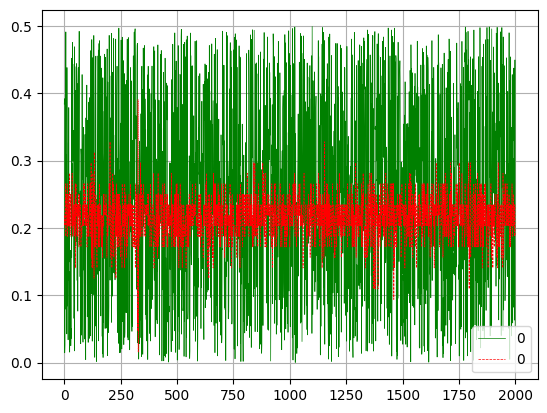

In [9]:
esn.evaluate(X_TS,Y_TS,plot=True)

## PRETRANING WITH OLD STYLE INTRINSIC PLASTICITY

In [10]:
ip_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.normalMask(N_UNITS), bias = True)

ip_reservoir.W_x = W_x
ip_reservoir.W_u = W_u
ip_reservoir.b_x = b_x
ip_reservoir.b_u = b_u

In [11]:
ip_reservoir.pre_train(X_TR, eta=0.000005, epochs=10,  learning_rule="online", verbose=True) #16

- Epoch: 1) | KL Divergence value: 2682.515869140625.
- Epoch: 2) | KL Divergence value: 2662.597900390625.
- Epoch: 3) | KL Divergence value: 2642.757080078125.
- Epoch: 4) | KL Divergence value: 2623.01220703125.
- Epoch: 5) | KL Divergence value: 2603.3837890625.
- Epoch: 6) | KL Divergence value: 2583.8935546875.
- Epoch: 7) | KL Divergence value: 2564.55224609375.
- Epoch: 8) | KL Divergence value: 2545.380126953125.
- Epoch: 9) | KL Divergence value: 2526.388427734375.
- Epoch: 10) | KL Divergence value: 2507.594970703125.


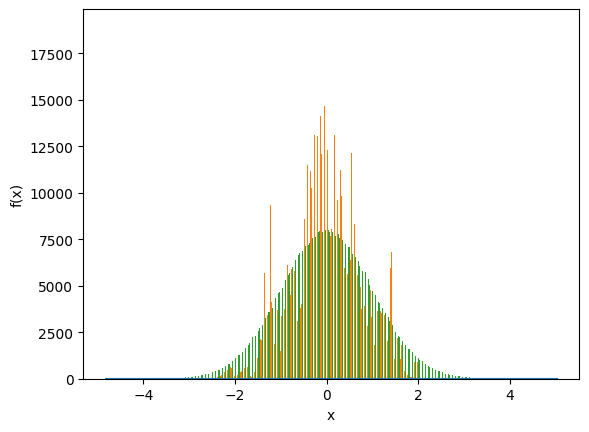

In [12]:
ip_reservoir.predict(X_TR, save_gradients=False, save_states=True)
ip_reservoir.plot_global_neural_activity()

In [13]:
ip_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.32745999097824097)  ACTUAL_STD == (0.023800868541002274)][ TARGET_MEAN == (-0.011924727819859982) TARGET_STD == (0.9994507431983948)]
Unit - (2): [ ACTUAL_MEAN == (1.0830222368240356)  ACTUAL_STD == (0.10526277124881744)][ TARGET_MEAN == (0.01855103112757206) TARGET_STD == (0.9987648129463196)]
Overall network: [ACTUAL_MEAN == (-0.009683115407824516)  ACTUAL_STD == (0.7612323760986328)]


## BIMODAL MIXTURE OF GAUSSIAN

In [14]:
# It seems that switching the "old" bias terms down (input bias and recurrent weights bias), 
# helps the algorithm converging earlier, letting the IP bias dominate the linear translation. 

bimodal_reservoir = IPReservoir(N = N_UNITS, mask=IPMask.mixedBimodalMask(N_UNITS), bias = False)

bimodal_reservoir.W_x = W_x
bimodal_reservoir.W_u = W_u
#bimodal_reservoir.b_x = b_x
#bimodal_reservoir.b_u = b_u

In [15]:
bimodal_reservoir.pre_train(X_TR, eta= 0.0000015, epochs=20,  learning_rule="online", verbose=True)

- Epoch: 1) | KL Divergence value: 3480.697021484375.
- Epoch: 2) | KL Divergence value: 3320.479736328125.
- Epoch: 3) | KL Divergence value: 3167.890380859375.
- Epoch: 4) | KL Divergence value: 3023.35693359375.
- Epoch: 5) | KL Divergence value: 2887.15771484375.
- Epoch: 6) | KL Divergence value: 2759.42822265625.
- Epoch: 7) | KL Divergence value: 2640.17578125.
- Epoch: 8) | KL Divergence value: 2529.292236328125.
- Epoch: 9) | KL Divergence value: 2426.572265625.
- Epoch: 10) | KL Divergence value: 2331.741943359375.
- Epoch: 11) | KL Divergence value: 2244.447509765625.
- Epoch: 12) | KL Divergence value: 2164.281494140625.
- Epoch: 13) | KL Divergence value: 2090.810791015625.
- Epoch: 14) | KL Divergence value: 2023.605712890625.
- Epoch: 15) | KL Divergence value: 1962.20263671875.


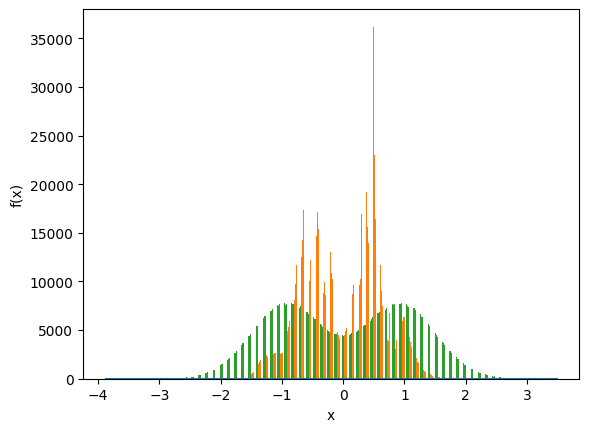

In [16]:
bimodal_reservoir.predict(X_TR, save_gradients=False, save_states=True)
bimodal_reservoir.plot_global_neural_activity()

In [17]:
bimodal_reservoir.print_IP_stats([0,1])

Unit - (1): [ ACTUAL_MEAN == (-0.4556511640548706)  ACTUAL_STD == (0.018020840361714363)][ TARGET_MEAN == (-0.9228565692901611) TARGET_STD == (0.5879047513008118)]
Unit - (2): [ ACTUAL_MEAN == (0.10223659127950668)  ACTUAL_STD == (0.09383894503116608)][ TARGET_MEAN == (0.9178042411804199) TARGET_STD == (0.5766518115997314)]
Overall network: [ACTUAL_MEAN == (-0.023325759917497635)  ACTUAL_STD == (0.6210675239562988)]


## EVAUALTUION IN ESN

In [18]:
from ESN import EchoStateNetwork

simple_esn = EchoStateNetwork(simple_reservoir)
ip_esn = EchoStateNetwork(ip_reservoir)
bimodal_esn = EchoStateNetwork(bimodal_reservoir)

simple_esn.reservoir.reset_initial_state()
ip_esn.reservoir.reset_initial_state()
bimodal_esn.reservoir.reset_initial_state()

simple_esn.train(X_TR, Y_TR, 0)
ip_esn.train(X_TR, Y_TR, 0)
bimodal_esn.train(X_TR, Y_TR, 0)


Reservoir warmed up with the first 100 time steps
Reservoir warmed up with the first 100 time steps
Reservoir warmed up with the first 100 time steps


array([0.26953125, 0.21875   , 0.23828125, ..., 0.28515625, 0.265625  ,
       0.265625  ], dtype=float32)

### COMPARISON ON TEST DATA

In [19]:
from Metrics import NRMSE, MSE

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.022633510059548115


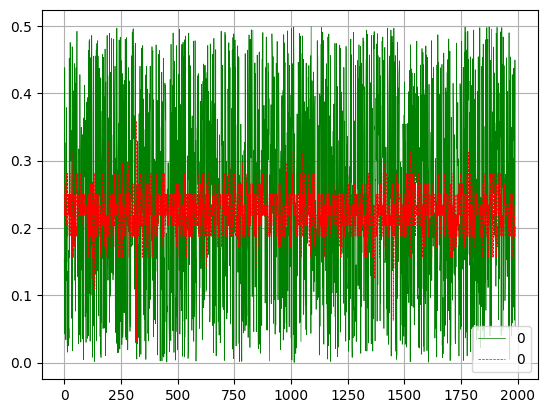

In [20]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { simple_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.0218497069311326


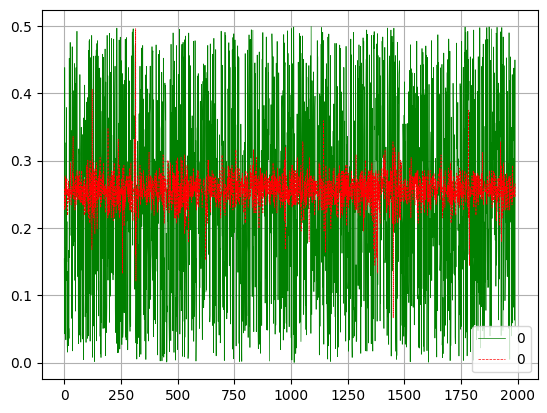

In [21]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { ip_esn.evaluate(X_TS, Y_TS, metric=MSE(), plot=True)}" )

NORMALIZED ROOT-MEAN SQUARE ERROR: 0.021867523589581096


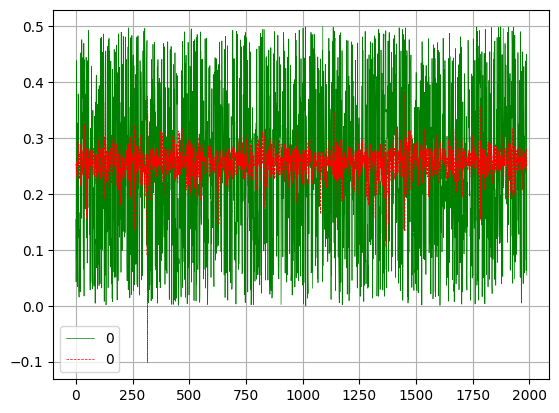

In [22]:
print(f"NORMALIZED ROOT-MEAN SQUARE ERROR: { bimodal_esn.evaluate(X_TS[10:None], Y_TS[10:None], metric=MSE(), plot=True)}" )

## LYAPUNOV EXPONENTS

In [23]:
simple_esn.reservoir.LCE(X_TS)

-1.5699091

In [24]:
ip_esn.reservoir.LCE(X_TS)

-1.2361007

In [25]:
bimodal_esn.reservoir.LCE(X_TS)

-1.3223672

## MEMORY CAPACITY

In [26]:
def mean_mc(esn: EchoStateNetwork, rep):
    mc = 0
    for _ in range(rep):
        mc += esn.MemoryCapacity()

    return mc/rep

In [27]:
mean_mc(simple_esn, 5)

tensor(6.9506)

In [28]:
mean_mc(ip_esn, 5)

tensor(7.1064)

In [29]:
mean_mc(bimodal_esn, 5)

tensor(7.1365)

## DEVIATION FROM LINEARITY

In [30]:
simple_esn.reservoir.de_fi()

0.04381662221132106

In [31]:
ip_esn.reservoir.de_fi()

0.04523822910012071

In [32]:
bimodal_esn.reservoir.de_fi()

0.0451100278670167